## 1. 라이브러리 Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

import os

In [2]:
os.getcwd()

'C:\\Users\\Park'

## 2 . 경로설정

In [3]:
class PATH:
    TRAIN = 'C:\\Users\\Park\\kaggle\\input\\digit-recognizer\\train.csv'
    TEST = 'C:\\Users\Park\\kaggle\\input\\digit-recognizer\\test.csv'
    
class CONFIG:
    lr = 0.001
    epoch = 10
    batch_size = 256

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## 3 . 학습데이터 만들기

In [5]:
df_train = pd.read_csv(PATH.TRAIN)

In [6]:
l = len(df_train)

In [7]:
_x = torch.Tensor(df_train.iloc[:,1:].values).reshape(l,28,28) / 256 #28*28의 형태로 변환후 0~1 사이의 값으로 변환
_x = _x.unsqueeze(1) # (batch_size, depth, width, height)로 형태를 맞추기 위한 코드
_y = torch.Tensor(df_train.iloc[:,0].values).type(torch.long)

train_x ,valid_x = _x[:39000],_x[39000:] #train,valid 분활
train_y ,valid_y = _y[:39000],_y[39000:]

In [8]:
class DigitDataset(Dataset):
    
    def __init__(self,x,y=None):
        super(DigitDataset).__init__()
        self.x = x
        self.y = y
        
    def __getitem__(self,idx):
        if self.y == None:
            return self.x[idx]
        return self.x[idx],self.y[idx]
    
    def __len__(self):
        return len(self.x)

In [9]:
trainset = DigitDataset(train_x,train_y)
validset = DigitDataset(valid_x,valid_y)
train_dl = DataLoader(trainset,batch_size = CONFIG.batch_size,shuffle=True)
valid_dl = DataLoader(validset,batch_size = CONFIG.batch_size)

## 4 . 학습모델 만들기

In [10]:
class DigitModel(nn.Module):
    
    def __init__(self):
        super(DigitModel,self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(1,32,3),
            nn.Conv2d(32,8,3),
            nn.Flatten(),
            nn.Linear(24*24*8,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )
        
    def forward(self,x):
        x = self.model(x)
        x = torch.softmax(x,dim=-1)
        return x

In [11]:
model = DigitModel().to(device)

## 5 . 모델 training

In [12]:
lossfn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=CONFIG.lr)

### 한 번의 epoch에 대하여 trainset 전체를 한번 학습하고 validset으로 검증이 이루어지는 코드

In [13]:
for e in range(CONFIG.epoch):
    print(f"Training on progress... {e+1}/{CONFIG.epoch}")
    acc =0
    total =0
    
    model.train() # train
    for x,y in train_dl:
        x = x.to(device)
        y = y.to(device)
        y_hat = model(x)
        loss = lossfn(y_hat,y)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    model.eval() #valid
    with torch.no_grad():
        for vx,vy in valid_dl:
            vx = vx.to(device)
            vy = vy.to(device)
            
            vy_hat = model(vx)
            pred = vy_hat.max(dim=1)[1]
            acc += (pred == vy).sum().item()
    print(f"Epoch {e+1} : Acc {100*acc/3000}")

Training on progress... 1/10
Epoch 1 : Acc 92.13333333333334
Training on progress... 2/10
Epoch 2 : Acc 94.0
Training on progress... 3/10
Epoch 3 : Acc 95.5
Training on progress... 4/10
Epoch 4 : Acc 95.36666666666666
Training on progress... 5/10
Epoch 5 : Acc 95.93333333333334
Training on progress... 6/10
Epoch 6 : Acc 96.5
Training on progress... 7/10
Epoch 7 : Acc 96.23333333333333
Training on progress... 8/10
Epoch 8 : Acc 96.33333333333333
Training on progress... 9/10
Epoch 9 : Acc 96.66666666666667
Training on progress... 10/10
Epoch 10 : Acc 96.3


## 6 . test data 예측

In [14]:
df_test= pd.read_csv(PATH.TEST)
l = len(df_test)
test_x = torch.Tensor(df_test.values).reshape(l,28,28) / 256
test_x = test_x.unsqueeze(1)

In [15]:
outputs = model(test_x)
_, pred = torch.max(outputs, 1)
pred = pred.cpu()

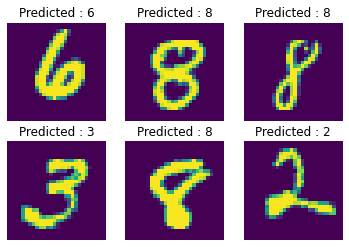

In [16]:
for i,img in enumerate(test_x[50:56]) :
    plt.subplot(2,3,i+1)
    plt.axis('off')
    plt.title(f"Predicted : {pred[50+i]}")
    plt.imshow(img.squeeze(0))

In [17]:
submission = pd.DataFrame({'ImageId': np.arange(1, (pred.size(0) + 1)), 'Label': pred})
submission.to_csv("submission.csv", index = False)